In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-04-10 18:21
@Project  :   Hands-on Deep Learning with PyTorch-learning_rate_scheduling
学习率调度
'''

# 导入所需的库
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

from layers.linears import L2LRWithBN
from layers.losses import loss_with_loader
from utils.data_gen_split import gen_reg_data, split_load_data
from utils.datasets import GenDataset
from utils.train_utils import train_test_model, fit_one_epoch

# 设置随机种子
torch.manual_seed(4111525)

学习率作为模型优化的重要超参数，其调整会对模型训练在诸多方面带来显著影响：
- 缓解Dead ReLU Problem：在ReLU激活函数叠加的神经网络中，由于ReLU本身负值归零的特性，可能会出现Dead ReLU Problem，通过减小学习率可以降低模型落入活性失效陷进的概率
- 提升模型表现：在学习率绝对数值的调整过程中，学习率对模型性能的影响整体呈现U型（以准确率评估指标时是倒U型）特征，即学习率过大或者过小都不好，学习过大可能会导致模型无法穿越狭窄的通道最终抵达最小值点，而学习率太小则容易在最小值点附近停止收敛，因此在进行模型训练时，需要找到一个适中的准确率取值来提升模型的表现
## 1.学习率调度基础
### 学习率对模型训练的影响
整体来看，如果模型学习率设置太大，虽然前期收敛速度较快，但容易出现收敛过程不稳定、收敛结果不佳、或者神经元活性失效等问题；而如果学习率设置太小，虽然收敛过程将相对平稳，并且能够有效规避神经元活性坏死的问题，但容易出现收敛速度慢、收敛结果不佳等问题。下面通过实验来观测不同学习率取值对模型收敛速度、收敛结果影响。

In [2]:
# 生成复杂数据
features, labels = gen_reg_data(w=(2, -1, 3, 1, 2), deg=2, bias=False)
labels.unsqueeze_(-1)

# 数据划分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels, batch_size=64)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x19822b93370>,
 <torch.utils.data.dataloader.DataLoader at 0x19822b93a30>)

In [3]:
# 超参数
num_epochs = 100

# 实例化模型
tanh_lr_003 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')
tanh_lr_001 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')
tanh_lr_0005 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')
tanh_lr_0001 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')

# 模型训练
train_losses_003, test_losses_003 = train_test_model(tanh_lr_003, train_loader, test_loader, num_epochs=num_epochs,
                                                     lr=0.03)
train_losses_001, test_losses_001 = train_test_model(tanh_lr_001, train_loader, test_loader, num_epochs=num_epochs,
                                                     lr=0.01)
train_losses_0005, test_losses_0005 = train_test_model(tanh_lr_0005, train_loader, test_loader, num_epochs=num_epochs,
                                                       lr=0.005)
train_losses_0001, test_losses_0001 = train_test_model(tanh_lr_0001, train_loader, test_loader, num_epochs=num_epochs,
                                                       lr=0.001)

Epoch: 100%|██████████| 100/100 [00:04<00:00, 23.89it/s]


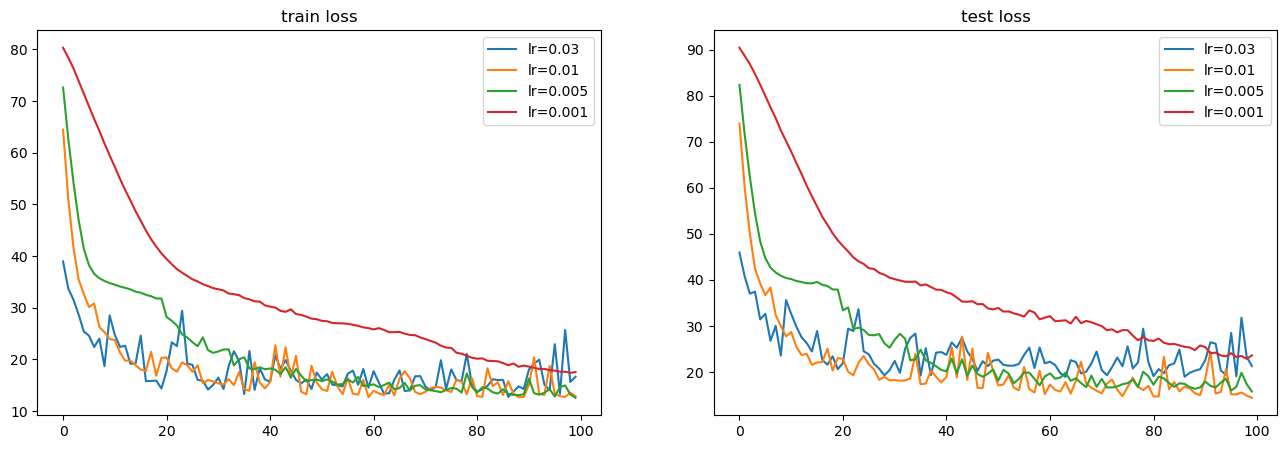

In [4]:
# 可视化损失
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(range(num_epochs), train_losses_003, label='lr=0.03')
plt.plot(range(num_epochs), train_losses_001, label='lr=0.01')
plt.plot(range(num_epochs), train_losses_0005, label='lr=0.005')
plt.plot(range(num_epochs), train_losses_0001, label='lr=0.001')
plt.title('train loss')
plt.legend()
plt.subplot(122)
plt.plot(range(num_epochs), test_losses_003, label='lr=0.03')
plt.plot(range(num_epochs), test_losses_001, label='lr=0.01')
plt.plot(range(num_epochs), test_losses_0005, label='lr=0.005')
plt.plot(range(num_epochs), test_losses_0001, label='lr=0.001')
plt.title('test loss')
plt.legend()
plt.show()

从实验结果可以看到，学习率较大的模型收敛速度较快，但效果却不一定最好，同时平稳性也较差，而学习率非常小的模型不仅收敛速度较慢，并且效果也不尽如人意。对于当前模型和当前数据来说，学习率为0.005时表现相对更好。
### 学习率调度基本概念
尽管学习率的调整会对模型训练造成很大的影响，但在进行学习率优化的时候一般不会采用同时训练多组学习率采用不同取值的模型来对比选择最佳学习率的方法，因为在实际生产生活中训练一个模型都非常耗费时间，为了一个超参数同时训练多组模型并不划算，一般是通过学习率伴随模型训练过程动态调整来让模型“又好又快”地收敛。同时，一个比较好的学习率动态调整策略是，先让学习率取得较大数值，从而能够让模型在最开始能够以较快的速度收敛；然后在经过一段时间迭代之后，将学习率调小，从而能够让收敛过程穿过损失函数的“隘口”，抵达更小的解。这种学习率调整的策略，就是**学习率调度**（learning rate scheduling）。
## 2.手动实现学习率调度
显然，学习率的调度是在fit过程中手动调整学习率，不同的epoch采用不同的学习率。下面手动实现学习率伴随迭代epoch次数的动态调整。

In [5]:
# 更新fit函数
def fit(model, criterion, optimizer, data_loader, cla=False, num_epochs=5):
    '''
    模型训练
    :param model: 待训练的模型
    :param criterion: 损失函数
    :param optimizer: 优化算法
    :param data_loader: 数据
    :param cla: 是否是分类任务
    :param num_epochs: 训练轮数
    :return: None
    '''
    for _ in tqdm(range(num_epochs), desc='Epoch'):
        fit_one_epoch(model, criterion, optimizer, data_loader, cla)

Epoch: 100%|██████████| 100/100 [00:03<00:00, 27.72it/s]


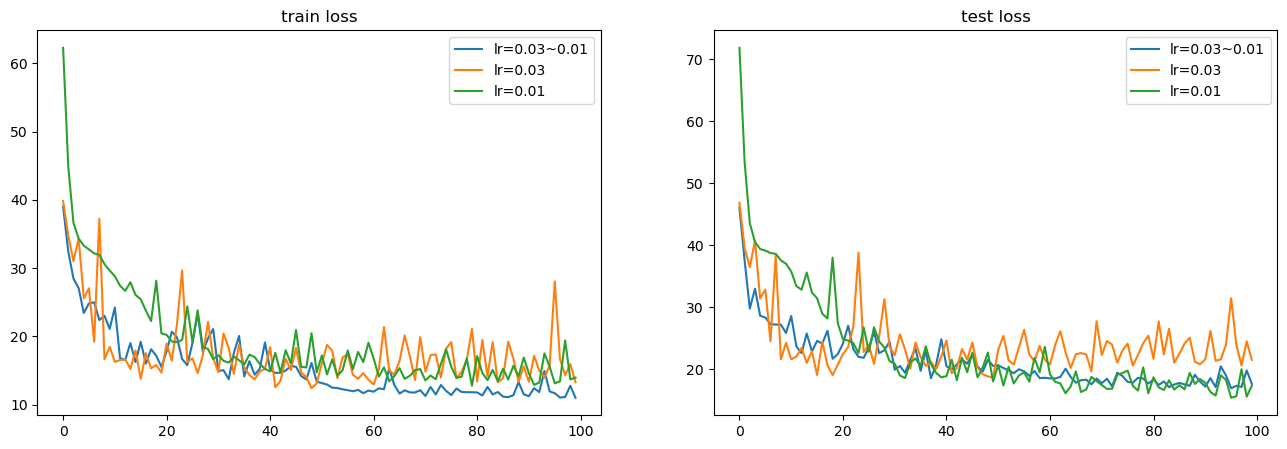

In [6]:
# 将需要调整学习率的epoch和对应的学习率存入列表
epoch_list = [50, 50]
lr_list = [0.03, 0.01]

# 损失列表
train_losses, test_losses = [], []

# 实例化模型
tanh_lr_003_001 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')  # 动态调整学习率
tanh_lr_003 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')  # 学习率：0.03
tanh_lr_001 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')  # 学习率：0.01

# 迭代训练：动态调整学习率
for epoch, lr in zip(epoch_list, lr_list):
    train_loss, test_loss = train_test_model(tanh_lr_003_001, train_loader, test_loader, num_epochs=epoch, lr=lr)
    train_losses.extend(train_loss)
    test_losses.extend(test_loss)

# 迭代训练：学习率：0.03
train_losses_003, test_losses_003 = train_test_model(tanh_lr_003, train_loader, test_loader, num_epochs=sum(epoch_list),
                                                     lr=0.03)

# 迭代训练：学习率：0.03
train_losses_001, test_losses_001 = train_test_model(tanh_lr_001, train_loader, test_loader, num_epochs=sum(epoch_list),
                                                     lr=0.01)

# 可视化损失
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(range(len(train_losses)), train_losses, label='lr=0.03~0.01')
plt.plot(range(len(train_losses_003)), train_losses_003, label='lr=0.03')
plt.plot(range(len(train_losses_001)), train_losses_001, label='lr=0.01')
plt.title('train loss')
plt.legend()
plt.subplot(122)
plt.plot(range(len(test_losses)), test_losses, label='lr=0.03~0.01')
plt.plot(range(len(test_losses_003)), test_losses_003, label='lr=0.03')
plt.plot(range(len(test_losses_001)), test_losses_001, label='lr=0.01')
plt.title('test loss')
plt.legend()
plt.show()

可以看到，手动调整模型学习率的模型在模型最终表现上比大学习率模型更好，收敛速度也比小学习率模型更快。为了可以实时观察模型效果，还可以在迭代训练时用TensorBoard记录训练过程。如下。

Epoch: 100%|██████████| 50/50 [00:01<00:00, 28.06it/s]


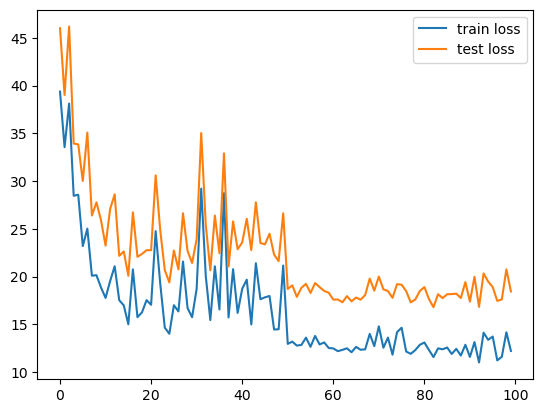

In [7]:
# 损失列表
train_losses, test_losses = [], []

# 实例化模型
tanh_lr_003_001 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')  # 动态调整学习率

# 实例化Writer对象
writer = SummaryWriter('../output/log')

# 迭代训练：动态调整学习率
cur_epoch = 0
for epoch, lr in zip(epoch_list, lr_list):
    train_loss, test_loss = train_test_model(tanh_lr_003_001, train_loader, test_loader, num_epochs=epoch, lr=lr)
    train_losses.extend(train_loss)
    test_losses.extend(test_loss)
    for epo, (tr_loss, te_loss) in enumerate(zip(train_loss, test_loss), cur_epoch):
        writer.add_scalar('train_loss', tr_loss, epo)
        writer.add_scalar('test_loss', te_loss, epo)
    cur_epoch += epoch

# 可视化损失
plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.plot(range(len(test_losses)), test_losses, label='test loss')
plt.legend()
plt.show()

运行前可以在命令行运行命令`tensorboard --logdir="../output/log"`启动TensorBoard服务，并访问[http://localhost:6006/](http://localhost:6006/)即可实时获取训练状态和中间结果。同时，这种方式还能实现断点恢复的效果，即从上一次训练结束的位置继续训练。实现如下。

Epoch: 100%|██████████| 50/50 [00:01<00:00, 29.90it/s]


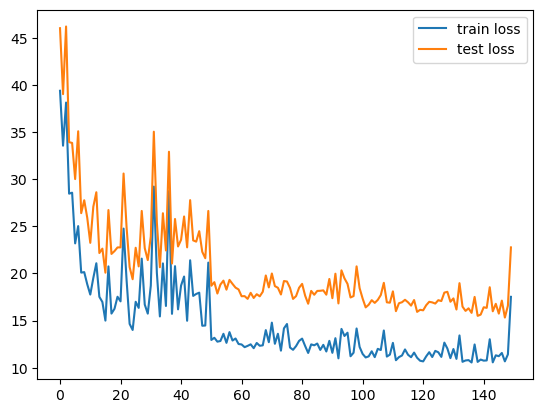

In [8]:
epoch_list = [50]
lr_list = [0.005]
for epoch, lr in zip(epoch_list, lr_list):
    train_loss, test_loss = train_test_model(tanh_lr_003_001, train_loader, test_loader, num_epochs=epoch, lr=lr)
    train_losses.extend(train_loss)
    test_losses.extend(test_loss)
    for epo, (tr_loss, te_loss) in enumerate(zip(train_loss, test_loss), cur_epoch):
        writer.add_scalar('train_loss', tr_loss, epo)
        writer.add_scalar('test_loss', te_loss, epo)
    cur_epoch += epoch

# 可视化损失
plt.plot(range(len(train_losses)), train_losses, label='train loss')
plt.plot(range(len(test_losses)), test_losses, label='test loss')
plt.legend()
plt.show()

可以看到，上面实现了恢复训练的效果。
### 常见学习率调度思路
从上面的实验可以得出，伴随模型遍历数据集次数增加学习率逐渐降低能够使得模型整体性能有所提升。在实际生产工作中，也会使用理论更加严谨的学习率调度方法来提升模型效果。从实现思路上划分，学习率调度的策略主要分为5类：
- 幂调度：将学习率设置为迭代次数$\t$的函数：$\eta(t)=\eta_0/(1+t/s)^c$，其中初始学习率$\(\eta_0\)$、幂$\(c\)$（通常设置为1）和步骤$\(s\)$是超参数。学习率在每一步都会下降，在$s$个步骤之后，它下降到$\eta_0/2$；再在$s$个步骤之后，它下降到$\eta_0/3$，以此类推，此调度开始下降，然后越来越慢。幂调度需要调整$\eta_0$、$s$和$c$。
- 指数调度：将学习率设置为$\eta(t)=\eta_0\ 0.1^{\frac{t}{s}}$，学习率每s步将逐渐下降10倍，幂调度越来越缓慢地降低学习率，而指数调度则使学习率每s步降低10倍。
- 分段恒定调度：对一些轮次使用恒定的学习率（例如对5个轮次，$\eta_0=0.01$），对于另外一些轮次使用较小的学习率（例如，对于50轮次，$\eta_0=0.001$），以此类推。
- 性能调度：每N步测量一次验证误差（就像提前停止一样），并且当误差停止下降时，将学习率降低$\lambda$倍。
- 周期调度：周期调度允许学习率在一个周期内进行先递增后递减的变化。
## 3.PyTorch实现学习率调度
### 优化器与状态字典state_dict
模型优化器是求解损失函数的函数，其中包含了模型训练的诸多关键信息，包括模型参数、模型学习率等，同时在进行模型训练时，我们也是通过优化器调整模型参数、归零模型梯度。

In [9]:
# 定义模型、优化器和损失函数
tanh_lr = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')
criterion = nn.MSELoss()
optimizer = optim.SGD(tanh_lr.parameters(), lr=0.05)
optimizer.state_dict()  # 查看优化器状态

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

优化器类的`state_dict()`方法返回一个包含优化器核心信息的字典，包含两个元素:
- 优化器状态（state）
- 优化器相关参数簇（param_groups）
    其中一个核心参数是，其代表着下一次模型训练的时候所带入的学习率。其他参数包括动量系数、特征权重、是否采用牛顿法，以及待训练参数索引params，其表示训练参数个数（其中一个矩阵算作一个参数），与模型通过`parameters()`方法获取的参数对应。

可以通过如下方法提取lr的值。

In [10]:
optimizer.state_dict()['param_groups'][0]['lr']  # 获取下一轮模型迭代的学习率

0.05

In [11]:
len(list(tanh_lr.parameters())), list(tanh_lr.parameters())  # 模型参数

(10,
 [Parameter containing:
  tensor([[ 0.2360, -0.1222,  0.3157,  0.0431,  0.3445],
          [-0.0677, -0.3576,  0.1403,  0.3411, -0.1085],
          [-0.0853,  0.3601,  0.1630,  0.2801,  0.4465],
          [-0.0144,  0.0373,  0.1271, -0.4327, -0.3276]], requires_grad=True),
  Parameter containing:
  tensor([-0.2457,  0.1764, -0.2730, -0.4454], requires_grad=True),
  Parameter containing:
  tensor([1., 1., 1., 1.], requires_grad=True),
  Parameter containing:
  tensor([0., 0., 0., 0.], requires_grad=True),
  Parameter containing:
  tensor([[ 0.4976, -0.1514, -0.1878, -0.2707],
          [-0.4884, -0.2517, -0.4851,  0.4252],
          [ 0.2676,  0.3398,  0.1989,  0.3590],
          [-0.0261,  0.2911,  0.4005, -0.2297]], requires_grad=True),
  Parameter containing:
  tensor([-0.3339, -0.1846,  0.3470,  0.2851], requires_grad=True),
  Parameter containing:
  tensor([1., 1., 1., 1.], requires_grad=True),
  Parameter containing:
  tensor([0., 0., 0., 0.], requires_grad=True),
  Parameter

### 模型保存与加载
模型也有`state_dict()`方法，调用该方法可以查看模型全部参数信息，通过`state_dict()`方法可以实现模型或优化器的本地保存于读取，优化器的本地保存与模型类似。模型的训练和保存，本质上都是针对模型的参数，模型的`state_dict()`包含了模型当前全部的参数信息，因此保存了模型的`state_dict()`就相当于保存了模型。

In [12]:
# 查看模型参数
tanh_state = tanh_lr.state_dict()
tanh_state

OrderedDict([('linear1.weight',
              tensor([[ 0.2360, -0.1222,  0.3157,  0.0431,  0.3445],
                      [-0.0677, -0.3576,  0.1403,  0.3411, -0.1085],
                      [-0.0853,  0.3601,  0.1630,  0.2801,  0.4465],
                      [-0.0144,  0.0373,  0.1271, -0.4327, -0.3276]])),
             ('linear1.bias', tensor([-0.2457,  0.1764, -0.2730, -0.4454])),
             ('bn1.weight', tensor([1., 1., 1., 1.])),
             ('bn1.bias', tensor([0., 0., 0., 0.])),
             ('bn1.running_mean', tensor([0., 0., 0., 0.])),
             ('bn1.running_var', tensor([1., 1., 1., 1.])),
             ('bn1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.4976, -0.1514, -0.1878, -0.2707],
                      [-0.4884, -0.2517, -0.4851,  0.4252],
                      [ 0.2676,  0.3398,  0.1989,  0.3590],
                      [-0.0261,  0.2911,  0.4005, -0.2297]])),
             ('linear2.bias', tensor([-0.3339, -0.1846,

In [13]:
# 保存模型参数到本地
model_path = '../output/saved_models/tanh_state.pth'
torch.save(tanh_state, model_path)

其中，torch.save函数的第1个参数是需要保存的模型参数，第2个参数则是保存到本地的路径。一般来说可以令其后缀为`.pt`或`.pth`。下面进行模型训练、调整模型参数。

In [14]:
# 模型训练
for inputs, labels in train_loader:
    preds = tanh_lr(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

# 再次查看模型参数
tanh_lr.state_dict()  # 参数实现更新

OrderedDict([('linear1.weight',
              tensor([[ 0.1821, -0.0201,  0.3805,  0.1270,  0.3709],
                      [ 0.0455, -0.5866, -0.0297,  0.2426,  0.0691],
                      [-0.0071,  0.2083,  0.1224,  0.1565,  0.6491],
                      [ 0.0197, -0.3445,  0.0995, -0.5491, -0.0144]])),
             ('linear1.bias', tensor([-0.2457,  0.1764, -0.2730, -0.4454])),
             ('bn1.weight', tensor([1.0697, 0.9779, 0.9889, 1.1073])),
             ('bn1.bias', tensor([-0.0122,  0.0721, -0.1701, -0.1974])),
             ('bn1.running_mean',
              tensor([-0.1669,  0.1023, -0.1576, -0.3283])),
             ('bn1.running_var', tensor([0.4726, 0.5347, 0.5762, 0.5401])),
             ('bn1.num_batches_tracked', tensor(13)),
             ('linear2.weight',
              tensor([[ 0.4472, -0.0719, -0.1161, -0.4905],
                      [-0.5036, -0.2296, -0.4588,  0.4675],
                      [ 0.2097,  0.3439,  0.1546,  0.5213],
                      [ 0.0223,

In [15]:
tanh_state  # tanh_state变量同步变化

OrderedDict([('linear1.weight',
              tensor([[ 0.1821, -0.0201,  0.3805,  0.1270,  0.3709],
                      [ 0.0455, -0.5866, -0.0297,  0.2426,  0.0691],
                      [-0.0071,  0.2083,  0.1224,  0.1565,  0.6491],
                      [ 0.0197, -0.3445,  0.0995, -0.5491, -0.0144]])),
             ('linear1.bias', tensor([-0.2457,  0.1764, -0.2730, -0.4454])),
             ('bn1.weight', tensor([1.0697, 0.9779, 0.9889, 1.1073])),
             ('bn1.bias', tensor([-0.0122,  0.0721, -0.1701, -0.1974])),
             ('bn1.running_mean',
              tensor([-0.1669,  0.1023, -0.1576, -0.3283])),
             ('bn1.running_var', tensor([0.4726, 0.5347, 0.5762, 0.5401])),
             ('bn1.num_batches_tracked', tensor(13)),
             ('linear2.weight',
              tensor([[ 0.4472, -0.0719, -0.1161, -0.4905],
                      [-0.5036, -0.2296, -0.4588,  0.4675],
                      [ 0.2097,  0.3439,  0.1546,  0.5213],
                      [ 0.0223,

此时，如果想还原模型中的参数，需要使用load_state_dict方法，将前面保存的本地模型参数替换当前的参数，如下。

In [16]:
# load_state_dict方法加载本地模型参数
tanh_lr.load_state_dict(torch.load(model_path))
# 查看模型参数
tanh_lr.state_dict()  # 恢复到之前的状态

OrderedDict([('linear1.weight',
              tensor([[ 0.2360, -0.1222,  0.3157,  0.0431,  0.3445],
                      [-0.0677, -0.3576,  0.1403,  0.3411, -0.1085],
                      [-0.0853,  0.3601,  0.1630,  0.2801,  0.4465],
                      [-0.0144,  0.0373,  0.1271, -0.4327, -0.3276]])),
             ('linear1.bias', tensor([-0.2457,  0.1764, -0.2730, -0.4454])),
             ('bn1.weight', tensor([1., 1., 1., 1.])),
             ('bn1.bias', tensor([0., 0., 0., 0.])),
             ('bn1.running_mean', tensor([0., 0., 0., 0.])),
             ('bn1.running_var', tensor([1., 1., 1., 1.])),
             ('bn1.num_batches_tracked', tensor(0)),
             ('linear2.weight',
              tensor([[ 0.4976, -0.1514, -0.1878, -0.2707],
                      [-0.4884, -0.2517, -0.4851,  0.4252],
                      [ 0.2676,  0.3398,  0.1989,  0.3590],
                      [-0.0261,  0.2911,  0.4005, -0.2297]])),
             ('linear2.bias', tensor([-0.3339, -0.1846,

### LambdaLR的基本使用
让优化器动态调整学习率的类记为学习率调度器类，其实例化对象即学习率调度器。在所有的学习率调度器中，LambdaLR是实现学习率调度最简单灵活、同时也是最通用的调度器。要使用LambdaLR来完成学习率调度，首先需要定义一个lambda匿名函数。

In [17]:
lr_lambda = lambda epoch: 0.5 ** epoch
# 模拟前2次迭代
lr_lambda(0), lr_lambda(1)

(1.0, 0.5)

需要注意，一般来说epoch取值从0开始，并且用于学习率调度的匿名函数参数取值为0时，输出结果不能为0。在有了匿名函数之后，接下来需要实例化一个LambdaLR学习率调度器，实例化时还需要传入需要完成调度的学习率所在的优化器，该优化器和学习率调度器的关联主要是通过学习率调度器来体现。

In [18]:
# 定义模型、优化器
tanh_lr = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')
optimizer = optim.SGD(tanh_lr.parameters(), lr=0.05)
optimizer.state_dict()  # 查看优化器状态

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [19]:
# 定义调度器：传入与之关联的优化器和lambda函数
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
optimizer.state_dict()  # 查看优化器状态

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

可以看到，此时优化器的参数簇中多了initial_lr参数，其代表初始学习率，也就是实例化优化器时输入的学习率，而lr表示下一次迭代时的学习率。
对于LambdaLR学习调度来说，优化器中的lr伴随模型迭代相应调整的方法如下：
$$lr = lr\_lambda(epoch) * initial\_lr$$
第1次实例化LambdaLR时epoch取值为0，此时优化器的lr计算结果为$lr_0 = 0.5^0 * 0.05 = 0.05$。在后续计算过程中，调度器每调用一次`step()`方法，epoch数值就会+1，学习率也会根据公式进行更新。下面实现完成一轮训练和更新学习率。

In [20]:
# 模型训练
for inputs, labels in train_loader:
    preds = tanh_lr(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
# 更新学习率
scheduler.step()
optimizer.state_dict()  # 查看优化器状态

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.025,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

可以看到，此时lr的取值0.025，其是由lr_lambda当epoch取值为1时的输出结果和initial_lr相乘之后的结果，即$lr = 0.5^1 * 0.05 = 0.025$。此时state参数也更新了参数的momentum_buffer状态。可以发现，`scheduler.step()`的真实作用就是令匿名函数的自变量+1，并让匿名函数的输出结果与initial_lr相乘，并把计算结果传给优化器，作为下一次优化器计算时的学习率。

需要注意，之所以将学习率调度器放在模型小批量梯度下降循环的外侧，也是因为一般来说遍历一次完整训练集（一个epoch）才会对学习率进行一次更新，而不是每次计算完一个小批数据就对模型学习率进行更新。同时，PyTorch中要求先进行优化器的step操作，再进行学习率调度的step操作。

下面通过简单的重复optimizer.step()与scheduler.step()来完成计算新学习率、并将新学习率传输给优化器的过程（实践中不推荐这种方式）。

In [21]:
optimizer.zero_grad()
optimizer.step()
scheduler.step()
optimizer.state_dict()  # lr=0.0125=lr_lambda(2) * 0.05

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.0125,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [22]:
optimizer.step()
scheduler.step()
optimizer.state_dict()  # lr=0.00625=lr_lambda(3) * 0.05

{'state': {0: {'momentum_buffer': None},
  1: {'momentum_buffer': None},
  2: {'momentum_buffer': None},
  3: {'momentum_buffer': None},
  4: {'momentum_buffer': None},
  5: {'momentum_buffer': None},
  6: {'momentum_buffer': None},
  7: {'momentum_buffer': None},
  8: {'momentum_buffer': None},
  9: {'momentum_buffer': None}},
 'param_groups': [{'lr': 0.00625,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'initial_lr': 0.05,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}]}

In [23]:
scheduler.state_dict()  # 查看调度器状态

{'base_lrs': [0.05],
 'last_epoch': 3,
 '_step_count': 4,
 'verbose': False,
 '_get_lr_called_within_step': False,
 '_last_lr': [0.00625],
 'lr_lambdas': [None]}

可以看到，调度器也有state_dict，其base_lrs对应优化器的initial_lr、_last_lr对应优化器的lr，同时还记录了上一个epoch值。可以发现，每一轮epoch都让模型学习率衰减50%是非常激进的，学习率的下降会很快，迭代几轮之后就逼近0了。下面通过绘制图像观察学习率衰减情况。

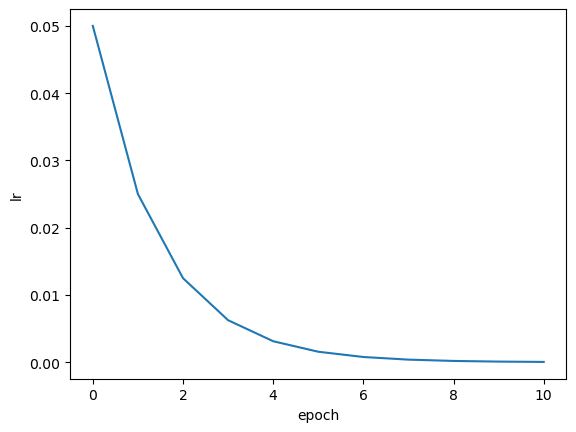

In [24]:
# 创建优化器和调度器
optimizer = optim.SGD(tanh_lr.parameters(), lr=0.05)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 保存学习率
lr_list = [optimizer.state_dict()['param_groups'][0]['lr']]

for epoch in range(10):
    optimizer.step()
    scheduler.step()
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

# 可视化
plt.plot(lr_list)
plt.xlabel('epoch')
plt.ylabel('lr')
plt.show()  # 学习率下降很快

### LambdaLR学习率调度

In [25]:
# fit函数中增加学习率调度
def train_test_model_with_scheduling(model, train_loader, test_loader, criterion, optimizer, scheduler,
                                     evaluation=loss_with_loader, cla=False, num_epochs=5):
    '''
    模型训练：带学习率调度
    :param model: 待训练的模型
    :param train_loader: 训练数据集
    :param test_loader: 测试数据集
    :param criterion: 损失函数
    :param optimizer: 优化算法
    :param scheduler: 学习率调度算法
    :param evaluation: 数据集损失计算函数
    :param cla: 是否是分类任务
    :param num_epochs: 训练轮数
    :return: 模型训练和测试过程损失
    '''
    train_losses, test_losses = [], []
    for _ in tqdm(range(num_epochs), desc='Epoch'):
        model.train()
        fit_one_epoch(model, criterion, optimizer, train_loader, cla)
        scheduler.step()
        model.eval()
        train_losses.append(evaluation(model, train_loader, criterion).item())
        test_losses.append(evaluation(model, test_loader, criterion).item())
    return train_losses, test_losses

In [26]:
# 定义衰减速度合适的lambda函数
lr_lambda = lambda epoch: 0.95 ** epoch
# 迭代几轮
lr_lambda(0), lr_lambda(10), lr_lambda(50), lr_lambda(100)  # 学习率每迭代一轮衰减5%，衰减速度相对较慢

(1.0, 0.5987369392383787, 0.07694497527671315, 0.0059205292203339975)

In [27]:
# 超参数
num_epochs = 100

# 1.带学习率调度
# 创建模型、优化器和调度器
tanh_lr_scheduled = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')
optimizer = optim.SGD(tanh_lr_scheduled.parameters(), lr=0.05)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 模型训练
train_losses_scheduled, test_losses_scheduled = train_test_model_with_scheduling(tanh_lr_scheduled, train_loader,
                                                                                 test_loader, criterion, optimizer,
                                                                                 scheduler, num_epochs=num_epochs)

# 查看最终学习率
last_lr = optimizer.state_dict()['param_groups'][0]['lr']
last_lr

Epoch: 100%|██████████| 100/100 [00:03<00:00, 26.75it/s]


0.0002960264610166999

In [28]:
# 2.学习率恒定0.05进行实验
tanh_lr_005 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')

# 模型训练
train_losses_005, test_losses_005 = train_test_model(tanh_lr_005, train_loader, test_loader, num_epochs=num_epochs,
                                                     lr=0.05)

# 3.学习率恒定为带学习率规划的最终学习率（0.0003）进行实验

tanh_lr_00003 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')

# 模型训练
train_losses_00003, test_losses_00003 = train_test_model(tanh_lr_00003, train_loader, test_loader,
                                                         num_epochs=num_epochs, lr=last_lr)

# 4.分段恒定调度：前一半迭代过程采用学习率0.05、后一半迭代过程采用学习率0.0003
epoch_list = [50, 50]
lr_list = [0.05, last_lr]
train_losses_005_00003, test_losses_005_00003 = [], []

# 实例化模型
tanh_lr_005_00003 = L2LRWithBN(activation=torch.tanh, in_features=5, bn_mode='pre')

# 迭代训练：动态调整学习率
for epoch, lr in zip(epoch_list, lr_list):
    train_loss, test_loss = train_test_model(tanh_lr_005_00003, train_loader, test_loader, num_epochs=epoch, lr=lr)
    train_losses_005_00003.extend(train_loss)
    test_losses_005_00003.extend(test_loss)

Epoch: 100%|██████████| 50/50 [00:01<00:00, 30.19it/s]


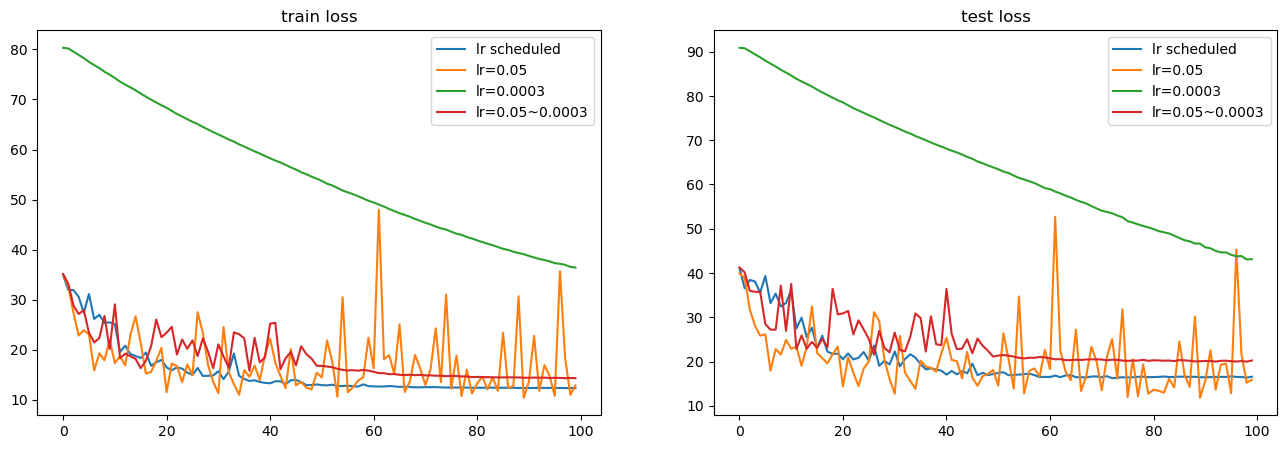

In [29]:
# 可视化4种情况下的损失
plt.figure(figsize=(16, 5))
plt.subplot(121)
plt.plot(range(len(train_losses_scheduled)), train_losses_scheduled, label='lr scheduled')
plt.plot(range(len(train_losses_005)), train_losses_005, label='lr=0.05')
plt.plot(range(len(train_losses_00003)), train_losses_00003, label='lr=0.0003')
plt.plot(range(len(train_losses_005_00003)), train_losses_005_00003, label='lr=0.05~0.0003')
plt.title('train loss')
plt.legend()
plt.subplot(122)
plt.plot(range(len(test_losses_scheduled)), test_losses_scheduled, label='lr scheduled')
plt.plot(range(len(test_losses_005)), test_losses_005, label='lr=0.05')
plt.plot(range(len(test_losses_00003)), test_losses_00003, label='lr=0.0003')
plt.plot(range(len(test_losses_005_00003)), test_losses_005_00003, label='lr=0.05~0.0003')
plt.title('test loss')
plt.legend()
plt.show()

可以看到，相比恒定大学习率（0.05）的模型，加入学习率调度策略的模型收敛效果更好、迭代更加平稳，且收敛速度较快；相比恒定小学习率（0.0003）的模型，拥有学习率调度的模型收敛更快；相比分段恒定调度，学习率动态调度策略也能收敛到一个更小的值。

由上面的结果可知，损失函数在超平面空间的图像比一般想象中要复杂得多，很多时候并不是越靠近全域最小值点附近的通道就越窄。正是由于损失函数的复杂性，才导致很多时候神经网络的内部看起来是个“黑箱”，并进一步导致神经网络的模型训练往往以模型结果为最终依据，这也是神经网络优化算法往往会诞生很多基本原理层面比较扎实、却找不到证明优化效果的具体理论依据的方法的原因。